# Import basic libraries needed

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import the data

In [7]:
start_date = '2000-01-01'
end_date = '2018-01-01'

In [8]:
'''
import pandas_datareader as pdr

df_to_save = pdr.DataReader(name='AAPL', data_source='yahoo', start=start_date, end=end_date)
df_to_save.head(5)

df_to_save.to_csv('AAPL_YAHOO.csv')

'''

df = pd.read_csv('AAPL_YAHOO7.csv', index_col='Date', parse_dates=True)

In [9]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.655498
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.431611
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.467196
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.253689
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.360442


In [10]:
df_close = df[['Close']].copy()
#df_close['Index'] = np.arange(len(df_close))
df_close.head()

,Close
Date,
2000-01-03,3.997768
2000-01-04,3.660714
2000-01-05,3.714286
2000-01-06,3.392857
2000-01-07,3.553571


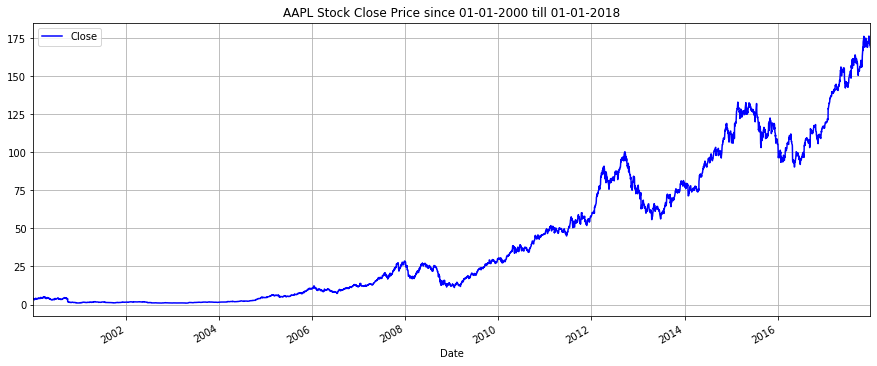

In [11]:
df_close.plot(figsize=(15, 6), 
                         color='blue', 
                         grid=True, 
                         title='AAPL Stock Close Price since 01-01-2000 till 01-01-2018')

# Train / Test split

In [12]:
len(df_close)

4528

In [13]:
# Train
train = df_close.iloc[:4400] # pandas.core.series.Series (4500,) **
train_index = train.index # pandas.core.indexes.datetimes.DatetimeIndex

# Test # 28 sessions
test = df_close.iloc[4400:] # pandas.core.series.Series (28,) **
test_index = test.index # pandas.core.indexes.datetimes.DatetimeIndex

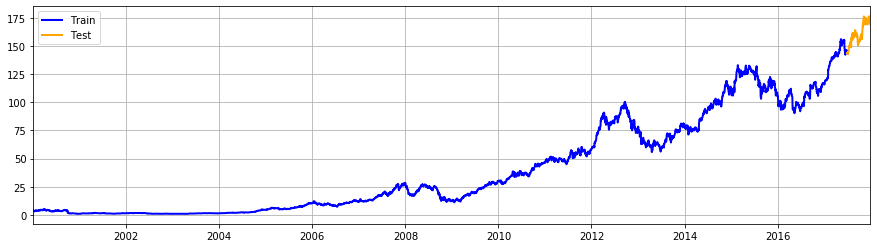

In [14]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train, lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

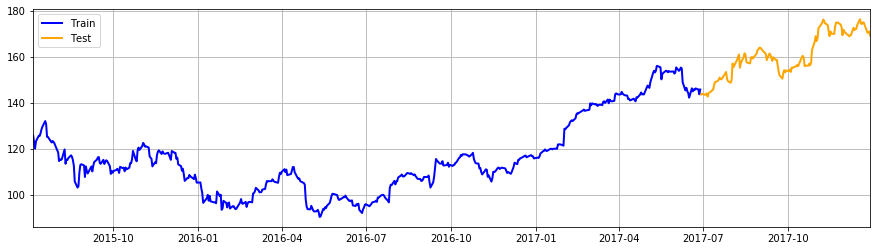

In [15]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train[-500:], lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

# Data preprocessing

### 1)  ```sklearn.preprocessing.MinMaxScaler()``` - data range made between 0 and 1

In [16]:
from sklearn.preprocessing import MinMaxScaler 

In [17]:
# From Pandas TimeSeries into NumPy array
# Train
train = train.values # numpy.ndarray (4400,)
train = train.reshape((len(train), 1)) # numpy.ndarray (4400, 1)

# Test
test = test.values # numpy.ndarray (128,)
test = test.reshape((len(test), 1)) # numpy.ndarray (128, 1)

In [18]:
# Fit the train data only sicne we don't want to give any additional info about values that model will predict
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
# Transform the data then export to Pandas TimeSeries as began
# Train
train_norm = scaler.transform(train) # numpy.ndarray (4400, 1)
train_norm = train_norm.tolist() # list of single value lists [[x], [y], [z]]
train_norm = np.squeeze(train_norm) # numpy.ndarray array([x, y, z])
train_norm = pd.Series(train_norm, train_index) # pandas.core.series.Series (4500,) **

# Test
test_norm = scaler.transform(test) # numpy.ndarray (128, 1)
test_norm = test_norm.tolist() # list of single value lists [[x], [y], [z]]
test_norm = np.squeeze(test_norm) # numpy.ndarray array([x, y, z])
test_norm = pd.Series(test_norm, test_index) # pandas.core.series.Series (28,) **

In [20]:
train_norm.head()

Date
2000-01-03    0.019725
2000-01-04    0.017553
2000-01-05    0.017898
2000-01-06    0.015827
2000-01-07    0.016862
dtype: float64

### 2) ```TimeseriesGenerator()``` - prepare train chunks for feeding model purposes.

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [22]:
n_input = 20

# All data and every single target are placed in the same set: train_norm
generator = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input,
                                batch_size=1)

# SECOND

In [23]:
n_input2 = 40

# All data and every single target are placed in the same set: train_norm
generator2 = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input2,
                                batch_size=1)

# Model building

## Model with generator 1
```n_input = 20```

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

# Model fit

In [25]:
import time

## Model fit with generator

In [26]:
elapsed_all = []
for i in range(3):
    model = Sequential()

    # n_input = 20
    model.add(Dense(20, activation='tanh', input_dim=n_input))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse')

    
    
    start = time.time()

    model.fit_generator(generator=generator, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end = time.time()
    elapsed = end - start
    elapsed_all.append(elapsed/60)
    
    # Model save
    model.save("my_MODEL1-tanh-tanh-linear-sgd_gen" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model.history.history['loss'])).to_csv("my_MODEL1-tanh-tanh-linear-sgd_gen_LOSS" + str(i) + ".csv")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 4s - loss: 8.4199e-04
Epoch 2/500
 - 4s - loss: 2.4085e-04
Epoch 3/500
 - 4s - loss: 1.7905e-04
Epoch 4/500
 - 4s - loss: 1.4864e-04
Epoch 5/500
 - 4s - loss: 1.3287e-04
Epoch 6/500
 - 4s - loss: 1.2008e-04
Epoch 7/500
 - 4s - loss: 1.1094e-04
Epoch 8/500
 - 4s - loss: 1.0492e-04
Epoch 9/500
 - 4s - loss: 1.0272e-04
Epoch 10/500
 - 4s - loss: 1.0096e-04
Epoch 11/500
 - 4s - loss: 9.7601e-05
Epoch 12/500
 - 4s - loss: 9.5199e-05
Epoch 13/500
 - 4s - loss: 9.2549e-05
Epoch 14/500
 - 4s - loss: 9.3857e-05
Epoch 15/500
 - 4s - loss: 8.9167e-05
Epoch 16/500
 - 4s - loss: 8.8954e-05
Epoch 17/500
 - 4s - loss: 8.4321e-05
Epoch 18/500
 - 4s - loss: 8.6035e-05
Epoch 19/500
 - 4s - loss: 8.4168e-05
Epoch 20/500
 - 4s - loss: 8.3693e-05
Epoch 21/500
 - 4s - loss: 8.3529e-05
Epoch 22/500
 - 4s - loss: 8.1879e-05
Epoch 23/500
 - 4s - loss: 7.9301e-05
Epoch 24/500
 -

Epoch 198/500
 - 5s - loss: 4.8935e-05
Epoch 199/500
 - 5s - loss: 4.7950e-05
Epoch 200/500
 - 5s - loss: 4.7611e-05
Epoch 201/500
 - 6s - loss: 4.8346e-05
Epoch 202/500
 - 5s - loss: 4.7566e-05
Epoch 203/500
 - 5s - loss: 4.7760e-05
Epoch 204/500
 - 5s - loss: 4.7196e-05
Epoch 205/500
 - 5s - loss: 4.7405e-05
Epoch 206/500
 - 5s - loss: 4.7714e-05
Epoch 207/500
 - 6s - loss: 4.7973e-05
Epoch 208/500
 - 5s - loss: 4.7882e-05
Epoch 209/500
 - 5s - loss: 4.6891e-05
Epoch 210/500
 - 5s - loss: 4.7343e-05
Epoch 211/500
 - 5s - loss: 4.8581e-05
Epoch 212/500
 - 5s - loss: 4.7227e-05
Epoch 213/500
 - 5s - loss: 4.7431e-05
Epoch 214/500
 - 5s - loss: 4.7244e-05
Epoch 215/500
 - 5s - loss: 4.7071e-05
Epoch 216/500
 - 6s - loss: 4.7079e-05
Epoch 217/500
 - 5s - loss: 4.6749e-05
Epoch 218/500
 - 5s - loss: 4.7295e-05
Epoch 219/500
 - 5s - loss: 4.7199e-05
Epoch 220/500
 - 5s - loss: 4.7825e-05
Epoch 221/500
 - 5s - loss: 4.5807e-05
Epoch 222/500
 - 6s - loss: 4.7471e-05
Epoch 223/500
 - 5s - los

 - 5s - loss: 4.3581e-05
Epoch 409/500
 - 5s - loss: 4.3937e-05
Epoch 410/500
 - 5s - loss: 4.4646e-05
Epoch 411/500
 - 5s - loss: 4.3810e-05
Epoch 412/500
 - 6s - loss: 4.3709e-05
Epoch 413/500
 - 5s - loss: 4.3678e-05
Epoch 414/500
 - 6s - loss: 4.4080e-05
Epoch 415/500
 - 5s - loss: 4.4321e-05
Epoch 416/500
 - 5s - loss: 4.3740e-05
Epoch 417/500
 - 5s - loss: 4.4735e-05
Epoch 418/500
 - 5s - loss: 4.3709e-05
Epoch 419/500
 - 5s - loss: 4.3292e-05
Epoch 420/500
 - 5s - loss: 4.3924e-05
Epoch 421/500
 - 5s - loss: 4.3498e-05
Epoch 422/500
 - 5s - loss: 4.4280e-05
Epoch 423/500
 - 5s - loss: 4.3309e-05
Epoch 424/500
 - 5s - loss: 4.2898e-05
Epoch 425/500
 - 5s - loss: 4.3991e-05
Epoch 426/500
 - 5s - loss: 4.3464e-05
Epoch 427/500
 - 5s - loss: 4.3522e-05
Epoch 428/500
 - 6s - loss: 4.4006e-05
Epoch 429/500
 - 5s - loss: 4.3612e-05
Epoch 430/500
 - 5s - loss: 4.3929e-05
Epoch 431/500
 - 5s - loss: 4.3592e-05
Epoch 432/500
 - 5s - loss: 4.3444e-05
Epoch 433/500
 - 6s - loss: 4.3936e-05


 - 6s - loss: 5.0553e-05
Epoch 122/500
 - 6s - loss: 5.0604e-05
Epoch 123/500
 - 5s - loss: 5.0888e-05
Epoch 124/500
 - 5s - loss: 5.1683e-05
Epoch 125/500
 - 5s - loss: 4.9803e-05
Epoch 126/500
 - 5s - loss: 5.0648e-05
Epoch 127/500
 - 6s - loss: 4.9096e-05
Epoch 128/500
 - 5s - loss: 5.0603e-05
Epoch 129/500
 - 5s - loss: 5.0036e-05
Epoch 130/500
 - 5s - loss: 4.9231e-05
Epoch 131/500
 - 5s - loss: 4.9902e-05
Epoch 132/500
 - 6s - loss: 4.9315e-05
Epoch 133/500
 - 6s - loss: 5.0577e-05
Epoch 134/500
 - 6s - loss: 4.9983e-05
Epoch 135/500
 - 5s - loss: 4.9503e-05
Epoch 136/500
 - 6s - loss: 4.9840e-05
Epoch 137/500
 - 5s - loss: 5.0364e-05
Epoch 138/500
 - 5s - loss: 4.9953e-05
Epoch 139/500
 - 5s - loss: 4.9809e-05
Epoch 140/500
 - 5s - loss: 4.9234e-05
Epoch 141/500
 - 5s - loss: 5.0308e-05
Epoch 142/500
 - 5s - loss: 5.0232e-05
Epoch 143/500
 - 5s - loss: 4.9016e-05
Epoch 144/500
 - 5s - loss: 4.9180e-05
Epoch 145/500
 - 5s - loss: 4.8939e-05
Epoch 146/500
 - 6s - loss: 4.9033e-05


Epoch 332/500
 - 4s - loss: 4.2792e-05
Epoch 333/500
 - 4s - loss: 4.3570e-05
Epoch 334/500
 - 4s - loss: 4.3255e-05
Epoch 335/500
 - 4s - loss: 4.4043e-05
Epoch 336/500
 - 4s - loss: 4.3685e-05
Epoch 337/500
 - 4s - loss: 4.3580e-05
Epoch 338/500
 - 4s - loss: 4.4247e-05
Epoch 339/500
 - 4s - loss: 4.3416e-05
Epoch 340/500
 - 4s - loss: 4.4080e-05
Epoch 341/500
 - 4s - loss: 4.4368e-05
Epoch 342/500
 - 4s - loss: 4.5000e-05
Epoch 343/500
 - 4s - loss: 4.4592e-05
Epoch 344/500
 - 4s - loss: 4.3867e-05
Epoch 345/500
 - 4s - loss: 4.3847e-05
Epoch 346/500
 - 4s - loss: 4.3656e-05
Epoch 347/500
 - 4s - loss: 4.3811e-05
Epoch 348/500
 - 4s - loss: 4.3648e-05
Epoch 349/500
 - 4s - loss: 4.3105e-05
Epoch 350/500
 - 4s - loss: 4.3455e-05
Epoch 351/500
 - 4s - loss: 4.3485e-05
Epoch 352/500
 - 4s - loss: 4.3158e-05
Epoch 353/500
 - 4s - loss: 4.4027e-05
Epoch 354/500
 - 4s - loss: 4.3491e-05
Epoch 355/500
 - 4s - loss: 4.4099e-05
Epoch 356/500
 - 4s - loss: 4.3424e-05
Epoch 357/500
 - 4s - los

Epoch 44/500
 - 4s - loss: 7.7147e-05
Epoch 45/500
 - 4s - loss: 7.5473e-05
Epoch 46/500
 - 4s - loss: 7.2928e-05
Epoch 47/500
 - 4s - loss: 7.5469e-05
Epoch 48/500
 - 4s - loss: 7.4373e-05
Epoch 49/500
 - 4s - loss: 7.4665e-05
Epoch 50/500
 - 4s - loss: 7.3635e-05
Epoch 51/500
 - 4s - loss: 7.2355e-05
Epoch 52/500
 - 4s - loss: 7.1505e-05
Epoch 53/500
 - 4s - loss: 7.1154e-05
Epoch 54/500
 - 4s - loss: 6.8792e-05
Epoch 55/500
 - 4s - loss: 6.9589e-05
Epoch 56/500
 - 4s - loss: 7.1478e-05
Epoch 57/500
 - 4s - loss: 6.7965e-05
Epoch 58/500
 - 4s - loss: 6.9880e-05
Epoch 59/500
 - 4s - loss: 6.8456e-05
Epoch 60/500
 - 4s - loss: 6.7059e-05
Epoch 61/500
 - 4s - loss: 6.7750e-05
Epoch 62/500
 - 4s - loss: 6.7490e-05
Epoch 63/500
 - 4s - loss: 6.6626e-05
Epoch 64/500
 - 4s - loss: 6.6977e-05
Epoch 65/500
 - 4s - loss: 6.5493e-05
Epoch 66/500
 - 4s - loss: 6.5150e-05
Epoch 67/500
 - 4s - loss: 6.5406e-05
Epoch 68/500
 - 4s - loss: 6.5554e-05
Epoch 69/500
 - 4s - loss: 6.6326e-05
Epoch 70/500

Epoch 256/500
 - 4s - loss: 4.7569e-05
Epoch 257/500
 - 4s - loss: 4.6715e-05
Epoch 258/500
 - 4s - loss: 4.6566e-05
Epoch 259/500
 - 4s - loss: 4.7581e-05
Epoch 260/500
 - 4s - loss: 4.6888e-05
Epoch 261/500
 - 4s - loss: 4.7670e-05
Epoch 262/500
 - 4s - loss: 4.7354e-05
Epoch 263/500
 - 4s - loss: 4.7028e-05
Epoch 264/500
 - 4s - loss: 4.6556e-05
Epoch 265/500
 - 4s - loss: 4.6514e-05
Epoch 266/500
 - 4s - loss: 4.7357e-05
Epoch 267/500
 - 4s - loss: 4.6901e-05
Epoch 268/500
 - 4s - loss: 4.6888e-05
Epoch 269/500
 - 4s - loss: 4.6984e-05
Epoch 270/500
 - 4s - loss: 4.7650e-05
Epoch 271/500
 - 4s - loss: 4.6353e-05
Epoch 272/500
 - 4s - loss: 4.7155e-05
Epoch 273/500
 - 4s - loss: 4.6575e-05
Epoch 274/500
 - 4s - loss: 4.7510e-05
Epoch 275/500
 - 4s - loss: 4.6750e-05
Epoch 276/500
 - 4s - loss: 4.6388e-05
Epoch 277/500
 - 4s - loss: 4.7175e-05
Epoch 278/500
 - 4s - loss: 4.6610e-05
Epoch 279/500
 - 4s - loss: 4.7331e-05
Epoch 280/500
 - 4s - loss: 4.6803e-05
Epoch 281/500
 - 4s - los

 - 4s - loss: 4.3990e-05
Epoch 467/500
 - 4s - loss: 4.3596e-05
Epoch 468/500
 - 4s - loss: 4.4094e-05
Epoch 469/500
 - 4s - loss: 4.3322e-05
Epoch 470/500
 - 4s - loss: 4.3655e-05
Epoch 471/500
 - 4s - loss: 4.3729e-05
Epoch 472/500
 - 4s - loss: 4.3939e-05
Epoch 473/500
 - 4s - loss: 4.2976e-05
Epoch 474/500
 - 4s - loss: 4.2706e-05
Epoch 475/500
 - 4s - loss: 4.3279e-05
Epoch 476/500
 - 4s - loss: 4.1814e-05
Epoch 477/500
 - 4s - loss: 4.3860e-05
Epoch 478/500
 - 4s - loss: 4.2769e-05
Epoch 479/500
 - 4s - loss: 4.3297e-05
Epoch 480/500
 - 4s - loss: 4.3287e-05
Epoch 481/500
 - 4s - loss: 4.2859e-05
Epoch 482/500
 - 4s - loss: 4.3387e-05
Epoch 483/500
 - 4s - loss: 4.3470e-05
Epoch 484/500
 - 4s - loss: 4.2877e-05
Epoch 485/500
 - 4s - loss: 4.3881e-05
Epoch 486/500
 - 4s - loss: 4.3399e-05
Epoch 487/500
 - 4s - loss: 4.3784e-05
Epoch 488/500
 - 4s - loss: 4.3663e-05
Epoch 489/500
 - 4s - loss: 4.2596e-05
Epoch 490/500
 - 4s - loss: 4.3608e-05
Epoch 491/500
 - 4s - loss: 4.3349e-05


In [32]:
elapsed_all
# [41.901100635528564, 36.79123011827469, 32.48806509971619]

[41.901100635528564, 36.79123011827469, 32.48806509971619]

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


## Model fit with generator2

In [74]:
elapsed2_all = []
for i in range(3):
    model2 = Sequential()

    # n_input = 20
    model2.add(Dense(20, activation='relu', input_dim=n_input2))
    model2.add(Dense(20, activation='relu'))
    model2.add(Dense(20, activation='relu'))
    model2.add(Dense(20, activation='relu'))
    model2.add(Dense(1, activation='linear'))

    model2.compile(optimizer='sgd', loss='mse')

    
    
    start2 = time.time()

    model2.fit_generator(generator=generator2, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end2 = time.time()
    elapsed2 = end2 - start2
    elapsed2_all.append(elapsed2/60)
    
    # Model save
    model2.save("my_MODEL1-relu-relu-relu-relu-linear-sgd_gen2" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model2.history.history['loss'])).to_csv("my_MODEL1-relu-relu-relu-relu-linear-sgd_gen2_LOSS" + str(i) + ".csv")

Epoch 1/500
 - 5s - loss: 0.0039
Epoch 2/500
 - 5s - loss: 4.2487e-04
Epoch 3/500
 - 5s - loss: 3.9195e-04
Epoch 4/500
 - 5s - loss: 3.5848e-04
Epoch 5/500
 - 5s - loss: 3.3198e-04
Epoch 6/500
 - 5s - loss: 3.1390e-04
Epoch 7/500
 - 5s - loss: 3.0055e-04
Epoch 8/500
 - 5s - loss: 2.8838e-04
Epoch 9/500
 - 5s - loss: 2.7338e-04
Epoch 10/500
 - 5s - loss: 2.6233e-04
Epoch 11/500
 - 5s - loss: 2.5254e-04
Epoch 12/500
 - 5s - loss: 2.4409e-04
Epoch 13/500
 - 5s - loss: 2.3570e-04
Epoch 14/500
 - 5s - loss: 2.3213e-04
Epoch 15/500
 - 5s - loss: 2.2468e-04
Epoch 16/500
 - 5s - loss: 2.1601e-04
Epoch 17/500
 - 5s - loss: 2.1202e-04
Epoch 18/500
 - 5s - loss: 2.0731e-04
Epoch 19/500
 - 5s - loss: 2.0403e-04
Epoch 20/500
 - 5s - loss: 1.9856e-04
Epoch 21/500
 - 5s - loss: 1.9699e-04
Epoch 22/500
 - 5s - loss: 1.8788e-04
Epoch 23/500
 - 5s - loss: 1.8721e-04
Epoch 24/500
 - 5s - loss: 1.8492e-04
Epoch 25/500
 - 5s - loss: 1.7927e-04
Epoch 26/500
 - 5s - loss: 1.7742e-04
Epoch 27/500
 - 5s - loss

Epoch 214/500
 - 5s - loss: 5.9150e-05
Epoch 215/500
 - 5s - loss: 5.9812e-05
Epoch 216/500
 - 5s - loss: 6.0044e-05
Epoch 217/500
 - 5s - loss: 6.0126e-05
Epoch 218/500
 - 5s - loss: 5.9663e-05
Epoch 219/500
 - 5s - loss: 5.9895e-05
Epoch 220/500
 - 5s - loss: 5.9185e-05
Epoch 221/500
 - 5s - loss: 5.8556e-05
Epoch 222/500
 - 5s - loss: 5.9286e-05
Epoch 223/500
 - 5s - loss: 5.9088e-05
Epoch 224/500
 - 5s - loss: 5.9245e-05
Epoch 225/500
 - 5s - loss: 5.8750e-05
Epoch 226/500
 - 5s - loss: 5.8017e-05
Epoch 227/500
 - 5s - loss: 5.8977e-05
Epoch 228/500
 - 5s - loss: 5.7791e-05
Epoch 229/500
 - 5s - loss: 5.8083e-05
Epoch 230/500
 - 5s - loss: 5.7701e-05
Epoch 231/500
 - 5s - loss: 5.8103e-05
Epoch 232/500
 - 5s - loss: 5.8064e-05
Epoch 233/500
 - 5s - loss: 5.8322e-05
Epoch 234/500
 - 5s - loss: 5.8936e-05
Epoch 235/500
 - 5s - loss: 5.7986e-05
Epoch 236/500
 - 5s - loss: 5.8524e-05
Epoch 237/500
 - 5s - loss: 5.7462e-05
Epoch 238/500
 - 5s - loss: 5.8029e-05
Epoch 239/500
 - 5s - los

 - 5s - loss: 4.9921e-05
Epoch 425/500
 - 5s - loss: 4.9162e-05
Epoch 426/500
 - 5s - loss: 4.8404e-05
Epoch 427/500
 - 5s - loss: 4.8836e-05
Epoch 428/500
 - 5s - loss: 4.8245e-05
Epoch 429/500
 - 5s - loss: 4.9320e-05
Epoch 430/500
 - 5s - loss: 4.8193e-05
Epoch 431/500
 - 5s - loss: 4.8597e-05
Epoch 432/500
 - 5s - loss: 4.8608e-05
Epoch 433/500
 - 5s - loss: 4.9318e-05
Epoch 434/500
 - 5s - loss: 4.8562e-05
Epoch 435/500
 - 5s - loss: 4.8415e-05
Epoch 436/500
 - 5s - loss: 4.8141e-05
Epoch 437/500
 - 5s - loss: 4.8866e-05
Epoch 438/500
 - 5s - loss: 4.9089e-05
Epoch 439/500
 - 5s - loss: 4.8877e-05
Epoch 440/500
 - 5s - loss: 4.9492e-05
Epoch 441/500
 - 5s - loss: 4.8441e-05
Epoch 442/500
 - 5s - loss: 4.9321e-05
Epoch 443/500
 - 5s - loss: 4.8729e-05
Epoch 444/500
 - 5s - loss: 4.8482e-05
Epoch 445/500
 - 5s - loss: 4.8754e-05
Epoch 446/500
 - 5s - loss: 4.8171e-05
Epoch 447/500
 - 5s - loss: 4.8098e-05
Epoch 448/500
 - 5s - loss: 4.8138e-05
Epoch 449/500
 - 5s - loss: 4.8975e-05


 - 5s - loss: 7.6137e-05
Epoch 138/500
 - 5s - loss: 7.5884e-05
Epoch 139/500
 - 5s - loss: 7.4776e-05
Epoch 140/500
 - 5s - loss: 7.3956e-05
Epoch 141/500
 - 5s - loss: 7.5246e-05
Epoch 142/500
 - 5s - loss: 7.3139e-05
Epoch 143/500
 - 5s - loss: 7.5499e-05
Epoch 144/500
 - 5s - loss: 7.5226e-05
Epoch 145/500
 - 5s - loss: 7.4693e-05
Epoch 146/500
 - 5s - loss: 7.3943e-05
Epoch 147/500
 - 5s - loss: 7.3391e-05
Epoch 148/500
 - 5s - loss: 7.4151e-05
Epoch 149/500
 - 5s - loss: 7.2717e-05
Epoch 150/500
 - 5s - loss: 7.3777e-05
Epoch 151/500
 - 5s - loss: 7.0972e-05
Epoch 152/500
 - 5s - loss: 7.3209e-05
Epoch 153/500
 - 5s - loss: 7.3177e-05
Epoch 154/500
 - 5s - loss: 7.2044e-05
Epoch 155/500
 - 5s - loss: 7.2692e-05
Epoch 156/500
 - 5s - loss: 7.3761e-05
Epoch 157/500
 - 5s - loss: 7.2689e-05
Epoch 158/500
 - 5s - loss: 7.1502e-05
Epoch 159/500
 - 5s - loss: 7.2145e-05
Epoch 160/500
 - 5s - loss: 7.1510e-05
Epoch 161/500
 - 5s - loss: 7.2495e-05
Epoch 162/500
 - 5s - loss: 7.2387e-05


Epoch 348/500
 - 5s - loss: 5.8906e-05
Epoch 349/500
 - 5s - loss: 5.8905e-05
Epoch 350/500
 - 5s - loss: 5.8000e-05
Epoch 351/500
 - 5s - loss: 5.8830e-05
Epoch 352/500
 - 5s - loss: 5.8599e-05
Epoch 353/500
 - 5s - loss: 5.8442e-05
Epoch 354/500
 - 5s - loss: 5.8155e-05
Epoch 355/500
 - 5s - loss: 5.8359e-05
Epoch 356/500
 - 5s - loss: 5.8691e-05
Epoch 357/500
 - 5s - loss: 5.8839e-05
Epoch 358/500
 - 5s - loss: 5.9286e-05
Epoch 359/500
 - 5s - loss: 5.8190e-05
Epoch 360/500
 - 5s - loss: 5.7400e-05
Epoch 361/500
 - 5s - loss: 5.8093e-05
Epoch 362/500
 - 5s - loss: 5.7767e-05
Epoch 363/500
 - 5s - loss: 5.7759e-05
Epoch 364/500
 - 5s - loss: 5.8827e-05
Epoch 365/500
 - 5s - loss: 5.7014e-05
Epoch 366/500
 - 5s - loss: 5.7238e-05
Epoch 367/500
 - 5s - loss: 5.7875e-05
Epoch 368/500
 - 5s - loss: 5.8582e-05
Epoch 369/500
 - 5s - loss: 5.8393e-05
Epoch 370/500
 - 5s - loss: 5.7720e-05
Epoch 371/500
 - 5s - loss: 5.8299e-05
Epoch 372/500
 - 5s - loss: 5.8053e-05
Epoch 373/500
 - 5s - los

Epoch 60/500
 - 5s - loss: 8.8185e-05
Epoch 61/500
 - 5s - loss: 8.9471e-05
Epoch 62/500
 - 5s - loss: 8.6674e-05
Epoch 63/500
 - 5s - loss: 8.7014e-05
Epoch 64/500
 - 5s - loss: 8.6119e-05
Epoch 65/500
 - 5s - loss: 8.6908e-05
Epoch 66/500
 - 5s - loss: 8.5975e-05
Epoch 67/500
 - 5s - loss: 8.5013e-05
Epoch 68/500
 - 5s - loss: 8.5811e-05
Epoch 69/500
 - 5s - loss: 8.4804e-05
Epoch 70/500
 - 5s - loss: 8.3198e-05
Epoch 71/500
 - 5s - loss: 8.4310e-05
Epoch 72/500
 - 5s - loss: 8.3877e-05
Epoch 73/500
 - 5s - loss: 8.2489e-05
Epoch 74/500
 - 5s - loss: 8.2873e-05
Epoch 75/500
 - 5s - loss: 8.2018e-05
Epoch 76/500
 - 5s - loss: 8.2263e-05
Epoch 77/500
 - 5s - loss: 8.2471e-05
Epoch 78/500
 - 5s - loss: 8.2314e-05
Epoch 79/500
 - 5s - loss: 8.1792e-05
Epoch 80/500
 - 5s - loss: 8.2268e-05
Epoch 81/500
 - 5s - loss: 8.0609e-05
Epoch 82/500
 - 5s - loss: 7.9132e-05
Epoch 83/500
 - 5s - loss: 8.1889e-05
Epoch 84/500
 - 5s - loss: 7.9544e-05
Epoch 85/500
 - 5s - loss: 8.0268e-05
Epoch 86/500

 - 5s - loss: 5.3791e-05
Epoch 272/500
 - 5s - loss: 5.3797e-05
Epoch 273/500
 - 5s - loss: 5.3962e-05
Epoch 274/500
 - 5s - loss: 5.3755e-05
Epoch 275/500
 - 5s - loss: 5.4380e-05
Epoch 276/500
 - 5s - loss: 5.3603e-05
Epoch 277/500
 - 5s - loss: 5.4453e-05
Epoch 278/500
 - 5s - loss: 5.3646e-05
Epoch 279/500
 - 5s - loss: 5.3405e-05
Epoch 280/500
 - 5s - loss: 5.4028e-05
Epoch 281/500
 - 5s - loss: 5.3356e-05
Epoch 282/500
 - 5s - loss: 5.2708e-05
Epoch 283/500
 - 5s - loss: 5.2491e-05
Epoch 284/500
 - 5s - loss: 5.4122e-05
Epoch 285/500
 - 5s - loss: 5.4493e-05
Epoch 286/500
 - 5s - loss: 5.3085e-05
Epoch 287/500
 - 5s - loss: 5.3745e-05
Epoch 288/500
 - 5s - loss: 5.3738e-05
Epoch 289/500
 - 5s - loss: 5.2638e-05
Epoch 290/500
 - 5s - loss: 5.3281e-05
Epoch 291/500
 - 5s - loss: 5.3218e-05
Epoch 292/500
 - 5s - loss: 5.3115e-05
Epoch 293/500
 - 5s - loss: 5.2967e-05
Epoch 294/500
 - 5s - loss: 5.3749e-05
Epoch 295/500
 - 5s - loss: 5.3837e-05
Epoch 296/500
 - 5s - loss: 5.3897e-05


Epoch 482/500
 - 5s - loss: 4.7380e-05
Epoch 483/500
 - 5s - loss: 4.8226e-05
Epoch 484/500
 - 5s - loss: 4.7000e-05
Epoch 485/500
 - 5s - loss: 4.7727e-05
Epoch 486/500
 - 5s - loss: 4.5988e-05
Epoch 487/500
 - 5s - loss: 4.7135e-05
Epoch 488/500
 - 5s - loss: 4.7211e-05
Epoch 489/500
 - 5s - loss: 4.6531e-05
Epoch 490/500
 - 5s - loss: 4.7398e-05
Epoch 491/500
 - 5s - loss: 4.6037e-05
Epoch 492/500
 - 5s - loss: 4.6741e-05
Epoch 493/500
 - 5s - loss: 4.7054e-05
Epoch 494/500
 - 5s - loss: 4.7351e-05
Epoch 495/500
 - 5s - loss: 4.5967e-05
Epoch 496/500
 - 5s - loss: 4.7145e-05
Epoch 497/500
 - 5s - loss: 4.7281e-05
Epoch 498/500
 - 5s - loss: 4.7048e-05
Epoch 499/500
 - 5s - loss: 4.7999e-05
Epoch 500/500
 - 5s - loss: 4.7666e-05


In [75]:
elapsed2_all
# [47.68329141139984, 48.15160831610362, 42.368217051029205]

[39.32658313512802, 39.47540321747462, 40.108188382784526]

In [76]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_77 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_78 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_79 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


## Model fit with generator2 (2)

In [29]:
elapsed3_all = []
for i in range(3):
    model3 = Sequential()

    # n_input = 20
    model3.add(Dense(40, activation='tanh', input_dim=n_input2))
    model3.add(Dense(40, activation='tanh'))
    model3.add(Dense(1, activation='linear'))

    model3.compile(optimizer='sgd', loss='mse')

    
    
    start3 = time.time()

    model3.fit_generator(generator=generator2, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end3 = time.time()
    elapsed3 = end3 - start3
    elapsed3_all.append(elapsed3/60)
    
    # Model save
    model3.save("my_MODEL1-tanh-tanh-linear-sgd_gen2_2" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model3.history.history['loss'])).to_csv("my_MODEL1-tanh-tanh-linear-sgd_gen2_2_LOSS" + str(i) + ".csv")

Epoch 1/500
 - 6s - loss: 7.1892e-04
Epoch 2/500
 - 6s - loss: 2.3766e-04
Epoch 3/500
 - 6s - loss: 2.0493e-04
Epoch 4/500
 - 6s - loss: 1.8733e-04
Epoch 5/500
 - 6s - loss: 1.7500e-04
Epoch 6/500
 - 7s - loss: 1.6146e-04
Epoch 7/500
 - 6s - loss: 1.5414e-04
Epoch 8/500
 - 5s - loss: 1.4834e-04
Epoch 9/500
 - 6s - loss: 1.4474e-04
Epoch 10/500
 - 5s - loss: 1.3634e-04
Epoch 11/500
 - 5s - loss: 1.3547e-04
Epoch 12/500
 - 6s - loss: 1.3146e-04
Epoch 13/500
 - 6s - loss: 1.2132e-04
Epoch 14/500
 - 6s - loss: 1.1916e-04
Epoch 15/500
 - 6s - loss: 1.1752e-04
Epoch 16/500
 - 6s - loss: 1.1322e-04
Epoch 17/500
 - 6s - loss: 1.1384e-04
Epoch 18/500
 - 6s - loss: 1.1152e-04
Epoch 19/500
 - 6s - loss: 1.0948e-04
Epoch 20/500
 - 6s - loss: 1.0884e-04
Epoch 21/500
 - 7s - loss: 1.0394e-04
Epoch 22/500
 - 6s - loss: 9.9628e-05
Epoch 23/500
 - 6s - loss: 1.0145e-04
Epoch 24/500
 - 6s - loss: 9.6233e-05
Epoch 25/500
 - 8s - loss: 9.6933e-05
Epoch 26/500
 - 7s - loss: 9.2874e-05
Epoch 27/500
 - 8s - 

Epoch 214/500
 - 6s - loss: 5.6150e-05
Epoch 215/500
 - 6s - loss: 5.3705e-05
Epoch 216/500
 - 6s - loss: 5.3877e-05
Epoch 217/500
 - 6s - loss: 5.3102e-05
Epoch 218/500
 - 6s - loss: 5.3091e-05
Epoch 219/500
 - 6s - loss: 5.3971e-05
Epoch 220/500
 - 6s - loss: 5.3417e-05
Epoch 221/500
 - 6s - loss: 5.4410e-05
Epoch 222/500
 - 6s - loss: 5.3711e-05
Epoch 223/500
 - 6s - loss: 5.5114e-05
Epoch 224/500
 - 6s - loss: 5.3718e-05
Epoch 225/500
 - 6s - loss: 5.4680e-05
Epoch 226/500
 - 6s - loss: 5.3645e-05
Epoch 227/500
 - 6s - loss: 5.4221e-05
Epoch 228/500
 - 6s - loss: 5.3433e-05
Epoch 229/500
 - 6s - loss: 5.4325e-05
Epoch 230/500
 - 7s - loss: 5.3604e-05
Epoch 231/500
 - 7s - loss: 5.3465e-05
Epoch 232/500
 - 6s - loss: 5.3770e-05
Epoch 233/500
 - 6s - loss: 5.2171e-05
Epoch 234/500
 - 6s - loss: 5.3520e-05
Epoch 235/500
 - 6s - loss: 5.3913e-05
Epoch 236/500
 - 6s - loss: 5.2365e-05
Epoch 237/500
 - 6s - loss: 5.2439e-05
Epoch 238/500
 - 6s - loss: 5.2350e-05
Epoch 239/500
 - 6s - los

 - 6s - loss: 4.9043e-05
Epoch 425/500
 - 6s - loss: 4.7683e-05
Epoch 426/500
 - 6s - loss: 4.9264e-05
Epoch 427/500
 - 6s - loss: 4.7616e-05
Epoch 428/500
 - 6s - loss: 4.7988e-05
Epoch 429/500
 - 6s - loss: 4.6497e-05
Epoch 430/500
 - 6s - loss: 4.8847e-05
Epoch 431/500
 - 6s - loss: 4.8637e-05
Epoch 432/500
 - 6s - loss: 4.8071e-05
Epoch 433/500
 - 6s - loss: 4.9030e-05
Epoch 434/500
 - 6s - loss: 4.8609e-05
Epoch 435/500
 - 6s - loss: 4.9446e-05
Epoch 436/500
 - 6s - loss: 4.8635e-05
Epoch 437/500
 - 6s - loss: 4.7038e-05
Epoch 438/500
 - 6s - loss: 4.9327e-05
Epoch 439/500
 - 6s - loss: 4.7576e-05
Epoch 440/500
 - 6s - loss: 4.7464e-05
Epoch 441/500
 - 6s - loss: 4.7631e-05
Epoch 442/500
 - 7s - loss: 4.7606e-05
Epoch 443/500
 - 6s - loss: 4.7742e-05
Epoch 444/500
 - 7s - loss: 4.7645e-05
Epoch 445/500
 - 7s - loss: 4.8230e-05
Epoch 446/500
 - 6s - loss: 4.7094e-05
Epoch 447/500
 - 6s - loss: 4.7904e-05
Epoch 448/500
 - 7s - loss: 4.8019e-05
Epoch 449/500
 - 7s - loss: 4.7812e-05


 - 7s - loss: 6.1791e-05
Epoch 138/500
 - 6s - loss: 5.8678e-05
Epoch 139/500
 - 6s - loss: 5.9012e-05
Epoch 140/500
 - 7s - loss: 5.8424e-05
Epoch 141/500
 - 7s - loss: 5.8990e-05
Epoch 142/500
 - 7s - loss: 5.8702e-05
Epoch 143/500
 - 7s - loss: 5.9720e-05
Epoch 144/500
 - 7s - loss: 5.9459e-05
Epoch 145/500
 - 7s - loss: 5.8473e-05
Epoch 146/500
 - 6s - loss: 5.9256e-05
Epoch 147/500
 - 7s - loss: 5.8600e-05
Epoch 148/500
 - 8s - loss: 6.0741e-05
Epoch 149/500
 - 10s - loss: 5.9141e-05
Epoch 150/500
 - 9s - loss: 5.8287e-05
Epoch 151/500
 - 11s - loss: 5.8131e-05
Epoch 152/500
 - 10s - loss: 5.8524e-05
Epoch 153/500
 - 10s - loss: 5.8047e-05
Epoch 154/500
 - 11s - loss: 5.8870e-05
Epoch 155/500
 - 11s - loss: 5.7525e-05
Epoch 156/500
 - 10s - loss: 5.9251e-05
Epoch 157/500
 - 13s - loss: 5.7557e-05
Epoch 158/500
 - 10s - loss: 5.7154e-05
Epoch 159/500
 - 9s - loss: 5.7547e-05
Epoch 160/500
 - 7s - loss: 5.7659e-05
Epoch 161/500
 - 6s - loss: 5.8493e-05
Epoch 162/500
 - 7s - loss: 5.

 - 7s - loss: 4.8409e-05
Epoch 348/500
 - 7s - loss: 4.7745e-05
Epoch 349/500
 - 7s - loss: 4.9976e-05
Epoch 350/500
 - 7s - loss: 4.8768e-05
Epoch 351/500
 - 7s - loss: 4.9574e-05
Epoch 352/500
 - 7s - loss: 4.9029e-05
Epoch 353/500
 - 7s - loss: 4.8957e-05
Epoch 354/500
 - 7s - loss: 4.9985e-05
Epoch 355/500
 - 7s - loss: 4.8757e-05
Epoch 356/500
 - 7s - loss: 4.8267e-05
Epoch 357/500
 - 7s - loss: 5.0878e-05
Epoch 358/500
 - 6s - loss: 4.8939e-05
Epoch 359/500
 - 7s - loss: 4.8401e-05
Epoch 360/500
 - 6s - loss: 4.9033e-05
Epoch 361/500
 - 7s - loss: 4.9342e-05
Epoch 362/500
 - 7s - loss: 4.9213e-05
Epoch 363/500
 - 7s - loss: 4.7257e-05
Epoch 364/500
 - 6s - loss: 4.6892e-05
Epoch 365/500
 - 8s - loss: 4.9146e-05
Epoch 366/500
 - 7s - loss: 4.9423e-05
Epoch 367/500
 - 6s - loss: 4.8311e-05
Epoch 368/500
 - 6s - loss: 4.8977e-05
Epoch 369/500
 - 6s - loss: 4.8811e-05
Epoch 370/500
 - 6s - loss: 4.9031e-05
Epoch 371/500
 - 6s - loss: 4.9222e-05
Epoch 372/500
 - 6s - loss: 4.9039e-05


 - 7s - loss: 8.1810e-05
Epoch 60/500
 - 6s - loss: 8.1850e-05
Epoch 61/500
 - 6s - loss: 7.9739e-05
Epoch 62/500
 - 7s - loss: 8.3422e-05
Epoch 63/500
 - 8s - loss: 8.0561e-05
Epoch 64/500
 - 7s - loss: 8.0423e-05
Epoch 65/500
 - 6s - loss: 8.1730e-05
Epoch 66/500
 - 6s - loss: 8.0441e-05
Epoch 67/500
 - 7s - loss: 7.9183e-05
Epoch 68/500
 - 6s - loss: 7.8591e-05
Epoch 69/500
 - 6s - loss: 7.9950e-05
Epoch 70/500
 - 7s - loss: 7.8738e-05
Epoch 71/500
 - 7s - loss: 7.9627e-05
Epoch 72/500
 - 7s - loss: 7.6614e-05
Epoch 73/500
 - 7s - loss: 7.9182e-05
Epoch 74/500
 - 7s - loss: 7.8197e-05
Epoch 75/500
 - 7s - loss: 7.7479e-05
Epoch 76/500
 - 7s - loss: 7.9156e-05
Epoch 77/500
 - 7s - loss: 7.5688e-05
Epoch 78/500
 - 7s - loss: 7.6840e-05
Epoch 79/500
 - 7s - loss: 7.7025e-05
Epoch 80/500
 - 7s - loss: 7.4856e-05
Epoch 81/500
 - 7s - loss: 7.5985e-05
Epoch 82/500
 - 7s - loss: 7.6480e-05
Epoch 83/500
 - 7s - loss: 7.5328e-05
Epoch 84/500
 - 6s - loss: 7.5090e-05
Epoch 85/500
 - 6s - loss

Epoch 271/500
 - 8s - loss: 5.5858e-05
Epoch 272/500
 - 7s - loss: 5.7057e-05
Epoch 273/500
 - 7s - loss: 5.8422e-05
Epoch 274/500
 - 7s - loss: 5.6494e-05
Epoch 275/500
 - 7s - loss: 5.4669e-05
Epoch 276/500
 - 6s - loss: 5.6555e-05
Epoch 277/500
 - 7s - loss: 5.5452e-05
Epoch 278/500
 - 7s - loss: 5.8637e-05
Epoch 279/500
 - 7s - loss: 5.6114e-05
Epoch 280/500
 - 7s - loss: 5.8367e-05
Epoch 281/500
 - 7s - loss: 5.3876e-05
Epoch 282/500
 - 7s - loss: 5.5003e-05
Epoch 283/500
 - 7s - loss: 5.6777e-05
Epoch 284/500
 - 7s - loss: 5.6715e-05
Epoch 285/500
 - 7s - loss: 5.5924e-05
Epoch 286/500
 - 6s - loss: 5.6786e-05
Epoch 287/500
 - 7s - loss: 5.5811e-05
Epoch 288/500
 - 7s - loss: 5.5822e-05
Epoch 289/500
 - 7s - loss: 5.4988e-05
Epoch 290/500
 - 6s - loss: 5.6399e-05
Epoch 291/500
 - 8s - loss: 5.5764e-05
Epoch 292/500
 - 8s - loss: 5.4925e-05
Epoch 293/500
 - 7s - loss: 5.5795e-05
Epoch 294/500
 - 7s - loss: 5.5169e-05
Epoch 295/500
 - 7s - loss: 5.6700e-05
Epoch 296/500
 - 6s - los

 - 7s - loss: 4.9576e-05
Epoch 482/500
 - 7s - loss: 5.1007e-05
Epoch 483/500
 - 7s - loss: 5.0037e-05
Epoch 484/500
 - 7s - loss: 5.0000e-05
Epoch 485/500
 - 7s - loss: 5.0649e-05
Epoch 486/500
 - 7s - loss: 5.1259e-05
Epoch 487/500
 - 7s - loss: 5.0460e-05
Epoch 488/500
 - 7s - loss: 5.0879e-05
Epoch 489/500
 - 7s - loss: 5.0682e-05
Epoch 490/500
 - 7s - loss: 5.0443e-05
Epoch 491/500
 - 7s - loss: 5.1655e-05
Epoch 492/500
 - 7s - loss: 4.9945e-05
Epoch 493/500
 - 7s - loss: 4.9369e-05
Epoch 494/500
 - 7s - loss: 4.8983e-05
Epoch 495/500
 - 6s - loss: 4.8932e-05
Epoch 496/500
 - 7s - loss: 4.9825e-05
Epoch 497/500
 - 7s - loss: 4.8653e-05
Epoch 498/500
 - 7s - loss: 5.1256e-05
Epoch 499/500
 - 7s - loss: 4.9685e-05
Epoch 500/500
 - 7s - loss: 4.9252e-05


In [30]:
elapsed3_all
# [54.20167486270269, 54.928441949685414, 56.472311945756275]

[54.20167486270269, 54.928441949685414, 56.472311945756275]

In [34]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_22 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 41        
Total params: 3,321
Trainable params: 3,321
Non-trainable params: 0
_________________________________________________________________


___

___

In [ ]:
'''# Model has been trained and saved already. Now just import model from the file

from keras.models import load_model

model = load_model('my_model_1.h5')
model.summary()'''

___

### 1 Day Ahead Prediction

In [ ]:
# Prediction
y_hat = model.predict(train_norm[-n_input:].values.reshape((1, n_input))).squeeze()
y_hat

In [ ]:
# Actual value
y = test_norm[0]
y

In [ ]:
# Error = y_hat - y
e = y_hat - y
e

### Error evaluation metrics:

In [ ]:
# MSE
# MAE
# MPE

___

### Loss function visualization

In [ ]:
'''model.history.history.keys()'''

In [ ]:
'''plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(model.history.history['loss'])'''

___

## Prediction set for next 20 days

In [38]:
predictions = []

# Initialize prediction process using very last 20 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch = train_norm[-n_input:].values.reshape((1, n_input)) # numpy.ndarray (1, 20)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat = model.predict(first_batch).squeeze() # numpy.ndarray ()
    predictions.append(y_hat.tolist())
    
    next_batch = np.append(first_batch, y_hat)[1:].reshape((1, n_input)) # numpy.ndarray (1, 20)
    first_batch = next_batch

In [39]:
# Do the inversion of normalized values
true_predictions = scaler.inverse_transform([predictions])[0]

# True predictions series object
df_true_predictions = pd.Series(true_predictions, test_index[:20])

___

### ANN Predictions against the Real Values 

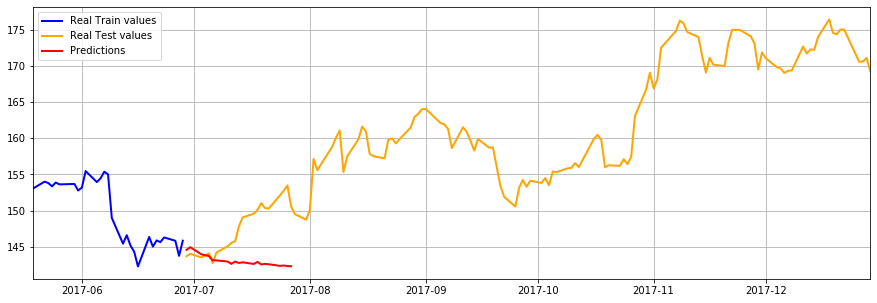

In [40]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions'])

## Prediction set for next 20 days 2

In [55]:
predictions2 = []

# Initialize prediction process using very last 40 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch2 = train_norm[-n_input2:].values.reshape((1, n_input2)) # numpy.ndarray (1, 40)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat2 = model2.predict(first_batch2).squeeze() # numpy.ndarray ()
    predictions2.append(y_hat2.tolist())
    
    next_batch2 = np.append(first_batch2, y_hat2)[1:].reshape((1, n_input2)) # numpy.ndarray (1, 40)
    first_batch2 = next_batch2

In [56]:
# Do the inversion of normalized values
true_predictions2 = scaler.inverse_transform([predictions2])[0]

# True predictions series object
df_true_predictions2 = pd.Series(true_predictions2, test_index[:20])

___

### ANN Predictions against the Real Values 

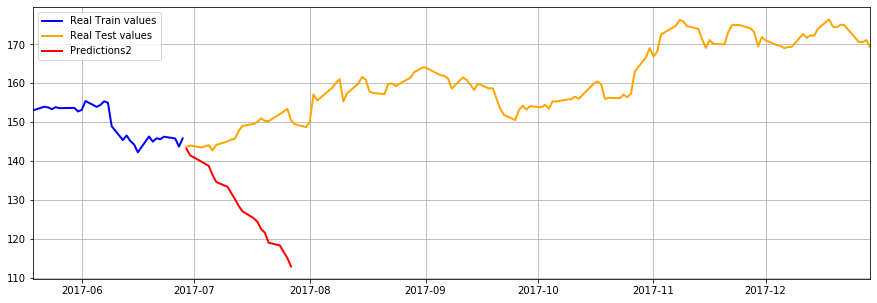

In [57]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions2, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions2'])

___

### Rolling mean against real data and predictions from ANN

In [ ]:
# Prediction of 20 sessions ahead
# It is rolling average with 20 days span
# Further predictions base on previous

predictions_20_avg = []

batch = train[-20:].squeeze()
for i in range(20):
    prediction = batch.mean()
    predictions_20_avg.append(prediction)
    
    
    next_batch = np.append(batch[1:], prediction)
    batch = next_batch

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(-9, 1),
         train[-10:],
         color='blue')

plt.plot(np.arange(1, len(test)+1),
         test,
         color='orange')

plt.plot(np.arange(1, len(true_predictions)+1),
         true_predictions,
         color='red')

plt.plot(np.arange(1, len(predictions_20_avg)+1),
         predictions_20_avg,
         color='grey')

plt.legend(['Real Train Data', 'Real Test Data', 'ANN Predictions', '20 Days AVG Predictions'])

____

In [ ]:
# Upper and lower bounds of avg +- std (20-days-span)

mean_20 = df[['Close']].rolling(window=20).mean()
std_20 = df[['Close']].rolling(window=20).std()

# Lower
std_minus = mean_20 - std_20
std_minus.dropna(inplace=True)

# Upper
std_plus = mean_20 + std_20
std_plus.dropna(inplace=True)

In [ ]:
# Plot 20 days avg window including sts, against real and predicted data
plt.figure(figsize=(15, 5))
plt.plot(df_close, lw=3, color='blue')
plt.plot(mean_20, lw=2, color='orange')

plt.fill_between(std_plus.index, std_minus.Close, std_plus.Close, alpha=0.3, color='orange')

plt.plot(df_true_predictions, lw=2, color='red', ls='--')


plt.autoscale(tight=True, axis='y')

plt.legend(['Close price', '20 days rolling avg. +/- 20 day rolling std.', 'Predictions'])

plt.xlim('2017-01-01', '2017-12-29')
plt.ylim(100, 180)